<a href="https://colab.research.google.com/github/nishant-jhaa/osteoarthritis-/blob/main/try%20cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-09-26 05:13:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-26 05:13:01 (89.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (512, 512)

In [6]:
# Walk through each directory
dataset = "/content/drive/MyDrive/osteoarthritis/train"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/osteoarthritis/train'.
There are 0 directories and 1540 images in '/content/drive/MyDrive/osteoarthritis/train/Osteoarthritis'.
There are 0 directories and 810 images in '/content/drive/MyDrive/osteoarthritis/train/Normal'.


In [7]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/osteoarthritis/train/Os...,Osteoarthritis
1,/content/drive/MyDrive/osteoarthritis/train/Os...,Osteoarthritis
2,/content/drive/MyDrive/osteoarthritis/train/Os...,Osteoarthritis
3,/content/drive/MyDrive/osteoarthritis/train/Os...,Osteoarthritis
4,/content/drive/MyDrive/osteoarthritis/train/Os...,Osteoarthritis
...,...,...
2345,/content/drive/MyDrive/osteoarthritis/train/No...,Normal
2346,/content/drive/MyDrive/osteoarthritis/train/No...,Normal
2347,/content/drive/MyDrive/osteoarthritis/train/No...,Normal
2348,/content/drive/MyDrive/osteoarthritis/train/No...,Normal


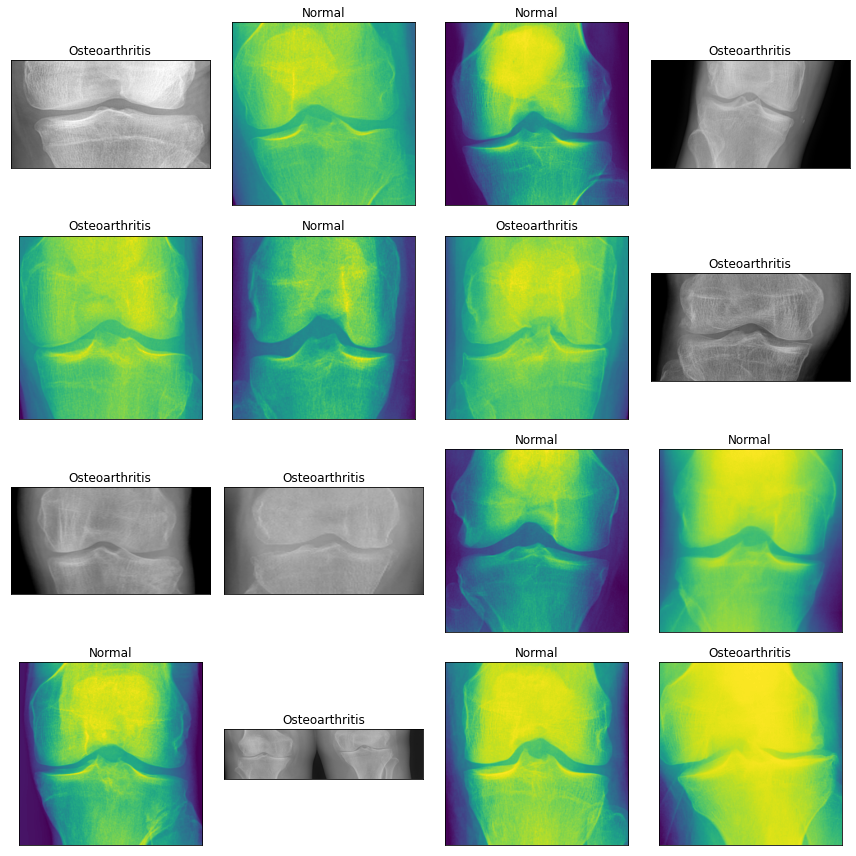

In [9]:
# Display 25 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 25)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [13]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1504 validated image filenames belonging to 2 classes.
Found 376 validated image filenames belonging to 2 classes.
Found 470 validated image filenames belonging to 2 classes.


In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(512,512),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# Create checkpoint callback
checkpoint_path = "knee_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [22]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [27]:
pretrained_model = VGG16(include_top = False,weights = 'imagenet',input_shape = (512,512,3))

58900480/58889256 [==============================] - 1s 0us/step


In [28]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [29]:
for ix in range(len(pretrained_model.layers)):
    print(ix,pretrained_model.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7fc99501b210>
1 <keras.layers.convolutional.Conv2D object at 0x7fc995011810>
2 <keras.layers.convolutional.Conv2D object at 0x7fc995550890>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fc99556e050>
4 <keras.layers.convolutional.Conv2D object at 0x7fc995011a10>
5 <keras.layers.convolutional.Conv2D object at 0x7fc995550310>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fc99557c090>
7 <keras.layers.convolutional.Conv2D object at 0x7fc9950b4c10>
8 <keras.layers.convolutional.Conv2D object at 0x7fc995584c90>
9 <keras.layers.convolutional.Conv2D object at 0x7fc995001a90>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fc995014e90>
11 <keras.layers.convolutional.Conv2D object at 0x7fc99502ee50>
12 <keras.layers.convolutional.Conv2D object at 0x7fc995550a90>
13 <keras.layers.convolutional.Conv2D object at 0x7fc995039ed0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fc995034390>
15 <keras.layers.convolutional.Conv2D object at 

In [30]:
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for i, layer in enumerate(pretrained_model.layers):
    print(i, layer.name, layer.trainable)
adam = Adam(learning_rate=0.00003)
pretrained_model.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])
pretrained_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0       

In [39]:
# Create checkpoint callback
checkpoint_path = "knee_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [40]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [51]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(train_images,val_images,
                    shuffle = True,
                    batch_size=32,
                    epochs = 30,
                    callbacks=checkpoint_callback)

ValueError: ignored